In [8]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score
import torch.nn.functional as F
import functools
from torch.optim import Adam
import torchvision.transforms as transforms
import os
import random
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix


In [ ]:

class PCamDataset(Dataset):
    def __init__(self, h5_x_path, h5_y_path=None, transform=None):
        self.x_path = h5_x_path
        self.y_path = h5_y_path
        self.transform = transform
        self.has_labels = h5_y_path is not None

        with h5py.File(h5_x_path, 'r') as x_file:
            self.length = len(x_file['x'])

        if self.has_labels:
            with h5py.File(h5_y_path, 'r') as y_file:
                self.labels = y_file['y'][:]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.x_path, 'r') as x_file:
            image = x_file['x'][idx].astype(np.uint8)

        image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            label = self.labels[idx].item()
            return image, label
        else:
            return image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# --------------------------
# Transform
# --------------------------
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(), # フリップ	水平方向・垂直方向
    transforms.RandomVerticalFlip(), # 垂直方向・水平方向
    transforms.RandomRotation(45), # 回転	最大 ±45° 回転
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05), # 明るさ・コントラスト・彩度・色相のランダム変化
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)), # アフィン変換	移動 (±15%)
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # 遠近変換
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # ぼかし
    transforms.RandomApply([transforms.RandomSolarize(threshold=0.5, p=0.3)], p=0.5), # ソラライズ	ランダムに適用（しきい値 0.5）
    transforms.ToTensor(), # テンソル変換
    transforms.Normalize(mean, std), # 正規化
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)), # ランダム消去
])

eval_transform = transforms.Compose([
    transforms.Resize(224), # リサイズ 
    transforms.CenterCrop(224), # 中央クロップ
    transforms.ToTensor(), # テンソル変換
    transforms.Normalize(mean, std), # 正規化
])




# データセット・データローダー
train_dataset = PCamDataset(
    '/home/gotou/Medical/camelyonpatch_level_2_split_train_x.h5',
    '/home/gotou/Medical/camelyonpatch_level_2_split_train_y.h5',
    transform=train_transform
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_dataset = PCamDataset(
    '/home/gotou/Medical/valid_x_uncompressed.h5',
    '/home/gotou/Medical/valid_y_uncompressed.h5',
    transform=eval_transform
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# 再現性確保
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# モデル準備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights) 
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from tqdm import tqdm

best_acc = 0  # 最良精度を記録する変数

train_losses = []
val_accuracies = []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Training Loss: {total_loss / len(train_loader):.4f}")

    # 評価
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = 100 * correct / total
    print(f"Validation accuracy after epoch {epoch+1}: {100 * correct / total:.2f}%")

        # トレーニング損失の記録
    train_losses.append(total_loss / len(train_loader))
    val_accuracies.append(acc)

       # --- モデルの保存（最高精度更新時のみ） ---
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'bestresnet50_2.pth')
        print("Best model saved.")


Epoch 1/30: 100%|██████████| 8192/8192 [20:12<00:00,  6.76it/s, loss=0.254] 

Epoch 1 Training Loss: 0.2680


Validation accuracy after epoch 1: 89.06%
Best model saved.


Epoch 2/30: 100%|██████████| 8192/8192 [20:19<00:00,  6.72it/s, loss=0.173] 

Epoch 2 Training Loss: 0.2089


Validation accuracy after epoch 2: 83.44%


Epoch 3/30: 100%|██████████| 8192/8192 [20:13<00:00,  6.75it/s, loss=0.182] 

Epoch 3 Training Loss: 0.1878


Validation accuracy after epoch 3: 89.18%
Best model saved.


Epoch 4/30: 100%|██████████| 8192/8192 [20:13<00:00,  6.75it/s, loss=0.111] 

Epoch 4 Training Loss: 0.1755


Validation accuracy after epoch 4: 89.30%
Best model saved.


Epoch 5/30: 100%|██████████| 8192/8192 [20:16<00:00,  6.73it/s, loss=0.161] 

Epoch 5 Training Loss: 0.1660


Validation accuracy after epoch 5: 85.08%


Epoch 6/30: 100%|██████████| 8192/8192 [20:05<00:00,  6.80it/s, loss=0.0765]

Epoch 6 Training Loss: 0.1587


Validation accuracy after epoch 6: 89.51%
Best model saved.


Epoch 7/30: 100%|██████████| 8192/8192 [20:04<00:00,  6.80it/s, loss=0.0511] 

Epoch 7 Training Loss: 0.1516


Validation accuracy after epoch 7: 85.15%


Epoch 8/30: 100%|██████████| 8192/8192 [20:17<00:00,  6.73it/s, loss=0.043] 

Epoch 8 Training Loss: 0.1461


Validation accuracy after epoch 8: 86.76%


Epoch 9/30: 100%|██████████| 8192/8192 [20:18<00:00,  6.73it/s, loss=0.0717] 

Epoch 9 Training Loss: 0.1415


Validation accuracy after epoch 9: 88.61%


Epoch 10/30: 100%|██████████| 8192/8192 [20:15<00:00,  6.74it/s, loss=0.346]  

Epoch 10 Training Loss: 0.1388


Validation accuracy after epoch 10: 87.93%


Epoch 11/30: 100%|██████████| 8192/8192 [20:05<00:00,  6.80it/s, loss=0.161]  

Epoch 11 Training Loss: 0.1342


Validation accuracy after epoch 11: 90.97%
Best model saved.


Epoch 12/30: 100%|██████████| 8192/8192 [20:05<00:00,  6.80it/s, loss=0.371]  

Epoch 12 Training Loss: 0.1311


Validation accuracy after epoch 12: 88.66%


Epoch 13/30: 100%|██████████| 8192/8192 [20:11<00:00,  6.76it/s, loss=0.137]  

Epoch 13 Training Loss: 0.1275


Validation accuracy after epoch 13: 87.08%


Epoch 14/30: 100%|██████████| 8192/8192 [20:21<00:00,  6.71it/s, loss=0.0617] 

Epoch 14 Training Loss: 0.1257


Validation accuracy after epoch 14: 85.55%


Epoch 15/30: 100%|██████████| 8192/8192 [20:15<00:00,  6.74it/s, loss=0.0828] 

Epoch 15 Training Loss: 0.1222


Validation accuracy after epoch 15: 88.02%


Epoch 16/30: 100%|██████████| 8192/8192 [20:21<00:00,  6.71it/s, loss=0.26]   

Epoch 16 Training Loss: 0.1197


Validation accuracy after epoch 16: 88.28%


Epoch 17/30: 100%|██████████| 8192/8192 [20:18<00:00,  6.72it/s, loss=0.114]  

Epoch 17 Training Loss: 0.1174


Validation accuracy after epoch 17: 88.76%


Epoch 18/30: 100%|██████████| 8192/8192 [20:18<00:00,  6.72it/s, loss=0.169]  

Epoch 18 Training Loss: 0.1148


Validation accuracy after epoch 18: 87.83%


Epoch 19/30: 100%|██████████| 8192/8192 [20:06<00:00,  6.79it/s, loss=0.231]  

Epoch 19 Training Loss: 0.1130


Validation accuracy after epoch 19: 88.09%


Epoch 20/30: 100%|██████████| 8192/8192 [20:03<00:00,  6.80it/s, loss=0.255]  

Epoch 20 Training Loss: 0.1116


Validation accuracy after epoch 20: 85.15%


Epoch 21/30: 100%|██████████| 8192/8192 [20:08<00:00,  6.78it/s, loss=0.0803] 

Epoch 21 Training Loss: 0.1091


Validation accuracy after epoch 21: 87.41%


Epoch 22/30: 100%|██████████| 8192/8192 [20:11<00:00,  6.76it/s, loss=0.119]  

Epoch 22 Training Loss: 0.1081


Validation accuracy after epoch 22: 88.26%


Epoch 23/30: 100%|██████████| 8192/8192 [20:06<00:00,  6.79it/s, loss=0.0424] 

Epoch 23 Training Loss: 0.1057


Validation accuracy after epoch 23: 87.57%


Epoch 24/30: 100%|██████████| 8192/8192 [20:05<00:00,  6.80it/s, loss=0.0368] 

Epoch 24 Training Loss: 0.1035


Validation accuracy after epoch 24: 88.81%


Epoch 25/30: 100%|██████████| 8192/8192 [20:22<00:00,  6.70it/s, loss=0.0333] 

Epoch 25 Training Loss: 0.1032


Validation accuracy after epoch 25: 84.07%


Epoch 26/30: 100%|██████████| 8192/8192 [20:17<00:00,  6.73it/s, loss=0.0676] 

Epoch 26 Training Loss: 0.0996


Validation accuracy after epoch 26: 87.12%


Epoch 27/30: 100%|██████████| 8192/8192 [20:09<00:00,  6.77it/s, loss=0.157]  

Epoch 27 Training Loss: 0.0997


Validation accuracy after epoch 27: 85.61%


Epoch 28/30: 100%|██████████| 8192/8192 [20:12<00:00,  6.76it/s, loss=0.0209] 

Epoch 28 Training Loss: 0.0972


Validation accuracy after epoch 28: 87.11%


Epoch 29/30: 100%|██████████| 8192/8192 [20:06<00:00,  6.79it/s, loss=0.166]  

Epoch 29 Training Loss: 0.0963


Validation accuracy after epoch 29: 83.89%


Epoch 30/30: 100%|██████████| 8192/8192 [20:07<00:00,  6.79it/s, loss=0.228]  

Epoch 30 Training Loss: 0.0953


Validation accuracy after epoch 30: 86.03%


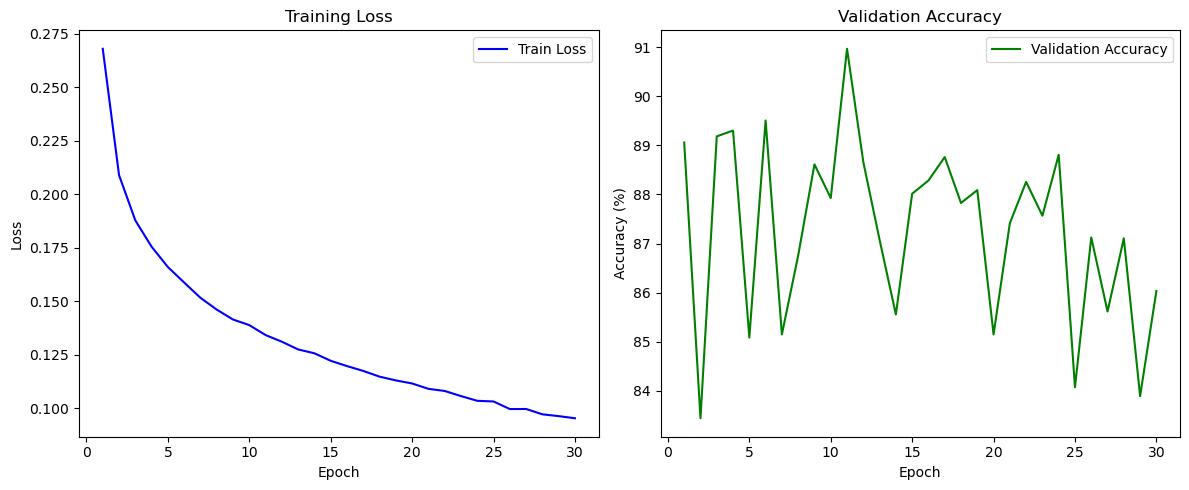

In [5]:
import matplotlib.pyplot as plt

# 損失と精度のグラフ化
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(12, 5))

# トレーニング損失
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# バリデーション精度
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
test_dataset = PCamDataset(
    '/home/gotou/Medical/camelyonpatch_level_2_split_test_x.h5',
    '/home/gotou/Medical/camelyonpatch_level_2_split_test_y.h5',
    transform=eval_transform # バリデーションと同じtransformでOK
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

model = resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('bestresnet50.pth', map_location=device))
model = model.to(device)
model.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # class 1の確率
        preds = torch.argmax(outputs, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# スコア算出
acc = accuracy_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)

# 結果表示
print(f"Test Accuracy : {acc:.4f}")
print(f"Test AUC      : {auc:.4f}")
print(f"Test F1 Score : {f1:.4f}")
print(f"Test Recall   : {recall:.4f}")
print(f"Test Precision: {precision:.4f}")


Test Accuracy : 0.8110
Test AUC      : 0.9028
Test F1 Score : 0.8292
Test Recall   : 0.9182
Test Precision: 0.7559


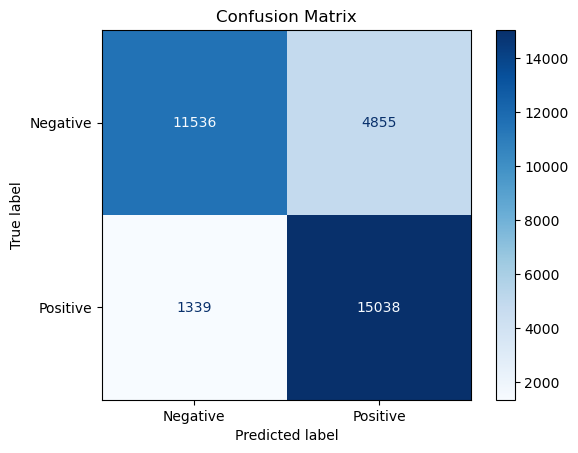

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
